In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C

2024-05-27 18:21:36.381714: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-27 18:21:38.002536: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 18:21:38.003730: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-27 18:21:38.542119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-27 18:21:38.544618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:bd:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key(y_train)

In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13427, 512, 512, 1) (13427, 512, 512, 1) (3339, 512, 512, 1) (3339, 512, 512, 1)


In [11]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(13427, 512, 512, 1) (3339, 512, 512, 1)


In [12]:
X_train, y_train, m_train = C.Helper.filter_slices(X_train, y_train, m_train)

(548, 512, 512, 1) (548, 512, 512, 1) (548, 512, 512, 1)


In [13]:
train_images_array, test_images_array = C.Helper.masked_image(X_train, m_train, X_test, m_test)

(548, 512, 512, 1) (3339, 512, 512, 1)


In [14]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [15]:
train_gen = C.Helper.augment(X_train_set, y_train_set)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [16]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)

(16, 512, 512, 1) (16, 512, 512, 1)


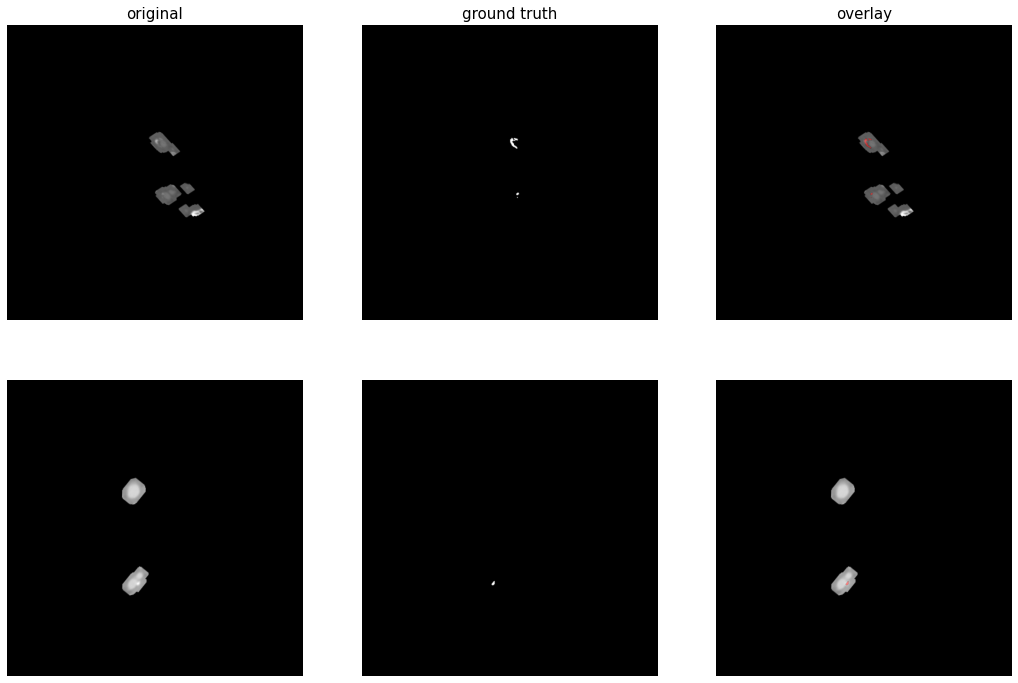

In [17]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [18]:
model = C.Helper.create_unet(X_train_set[0].shape)

2024-05-27 18:25:01.649399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-27 18:25:01.653499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:bd:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-27 18:25:01.678077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-27 18:25:01.682023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-27 18:25:01.685497: I tensorflow/core

In [19]:
model, history = C.Helper.train_unet(train_gen, X_train_set, y_train_set, X_val, y_val, model, epochs=500)

2024-05-27 18:25:02.681196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-27 18:25:02.698768: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/500


2024-05-27 18:25:04.632186: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-27 18:25:05.253887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-27 18:25:05.928927: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-27 18:25:05.928951: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-27 18:25:05.929016: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-27 18:25:06.002639: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-27 18:25:06.759573: I tensorflow/stream_exec

13/13 [==============================] - 30s 1s/step - loss: 0.7068 - iou: 1.6810e-04 - iou_thresholded: 2.2940e-04 - val_loss: 0.7752 - val_iou: 2.0210e-05 - val_iou_thresholded: 1.8661e-04
Epoch 2/500
13/13 [==============================] - 11s 815ms/step - loss: 0.5967 - iou: 2.0996e-04 - iou_thresholded: 0.0056 - val_loss: 0.2513 - val_iou: 6.9286e-06 - val_iou_thresholded: 2.3212e-04
Epoch 3/500
13/13 [==============================] - 16s 828ms/step - loss: 0.5249 - iou: 2.0657e-04 - iou_thresholded: 0.0112 - val_loss: 0.3232 - val_iou: 2.6625e-06 - val_iou_thresholded: 0.0013
Epoch 4/500
13/13 [==============================] - 11s 828ms/step - loss: 0.4565 - iou: 1.9454e-04 - iou_thresholded: 0.0158 - val_loss: 0.3743 - val_iou: 7.1254e-05 - val_iou_thresholded: 0.0013
Epoch 5/500
13/13 [==============================] - 11s 815ms/step - loss: 0.3863 - iou: 2.2329e-04 - iou_thresholded: 0.0248 - val_loss: 0.3474 - val_iou: 1.0522e-04 - val_iou_thresholded: 0.0013
Epoch 6/500
1

Epoch 43/500
13/13 [==============================] - 11s 820ms/step - loss: 0.0053 - iou: 0.0107 - iou_thresholded: 0.2299 - val_loss: 0.0053 - val_iou: 0.0026 - val_iou_thresholded: 0.0343
Epoch 44/500
13/13 [==============================] - 11s 831ms/step - loss: 0.0050 - iou: 0.0116 - iou_thresholded: 0.2412 - val_loss: 0.0051 - val_iou: 0.0048 - val_iou_thresholded: 0.0931
Epoch 45/500
13/13 [==============================] - 11s 831ms/step - loss: 0.0048 - iou: 0.0137 - iou_thresholded: 0.2855 - val_loss: 0.0049 - val_iou: 0.0053 - val_iou_thresholded: 0.1099
Epoch 46/500
13/13 [==============================] - 10s 812ms/step - loss: 0.0046 - iou: 0.0131 - iou_thresholded: 0.2716 - val_loss: 0.0046 - val_iou: 0.0041 - val_iou_thresholded: 0.0691
Epoch 47/500
13/13 [==============================] - 11s 841ms/step - loss: 0.0044 - iou: 0.0154 - iou_thresholded: 0.2842 - val_loss: 0.0045 - val_iou: 0.0058 - val_iou_thresholded: 0.1119
Epoch 48/500
13/13 [=========================

Epoch 86/500
13/13 [==============================] - 11s 818ms/step - loss: 0.0016 - iou: 0.0474 - iou_thresholded: 0.3354 - val_loss: 0.0017 - val_iou: 0.0349 - val_iou_thresholded: 0.2470
Epoch 87/500
13/13 [==============================] - 11s 834ms/step - loss: 0.0015 - iou: 0.0445 - iou_thresholded: 0.3101 - val_loss: 0.0016 - val_iou: 0.0313 - val_iou_thresholded: 0.2503
Epoch 88/500
13/13 [==============================] - 11s 827ms/step - loss: 0.0015 - iou: 0.0595 - iou_thresholded: 0.3774 - val_loss: 0.0016 - val_iou: 0.0345 - val_iou_thresholded: 0.2705
Epoch 89/500
13/13 [==============================] - 10s 803ms/step - loss: 0.0015 - iou: 0.0535 - iou_thresholded: 0.3300 - val_loss: 0.0017 - val_iou: 0.0320 - val_iou_thresholded: 0.1953
Epoch 90/500
13/13 [==============================] - 11s 829ms/step - loss: 0.0014 - iou: 0.0555 - iou_thresholded: 0.3626 - val_loss: 0.0015 - val_iou: 0.0357 - val_iou_thresholded: 0.2692
Epoch 91/500
13/13 [=========================

13/13 [==============================] - 11s 827ms/step - loss: 9.0108e-04 - iou: 0.1183 - iou_thresholded: 0.4087 - val_loss: 9.9749e-04 - val_iou: 0.0570 - val_iou_thresholded: 0.2406
Epoch 129/500
13/13 [==============================] - 11s 830ms/step - loss: 8.8554e-04 - iou: 0.1063 - iou_thresholded: 0.3919 - val_loss: 9.7634e-04 - val_iou: 0.0653 - val_iou_thresholded: 0.2782
Epoch 130/500
13/13 [==============================] - 10s 815ms/step - loss: 8.3787e-04 - iou: 0.1081 - iou_thresholded: 0.4220 - val_loss: 9.5072e-04 - val_iou: 0.0790 - val_iou_thresholded: 0.3406
Epoch 131/500
13/13 [==============================] - 11s 830ms/step - loss: 9.0552e-04 - iou: 0.1173 - iou_thresholded: 0.4059 - val_loss: 9.6331e-04 - val_iou: 0.0813 - val_iou_thresholded: 0.3556
Epoch 132/500
13/13 [==============================] - 10s 801ms/step - loss: 9.3609e-04 - iou: 0.1127 - iou_thresholded: 0.3687 - val_loss: 9.7013e-04 - val_iou: 0.0787 - val_iou_thresholded: 0.3321
Epoch 133/500


13/13 [==============================] - 11s 836ms/step - loss: 6.2263e-04 - iou: 0.1848 - iou_thresholded: 0.4607 - val_loss: 8.2323e-04 - val_iou: 0.0616 - val_iou_thresholded: 0.1564
Epoch 170/500
13/13 [==============================] - 11s 818ms/step - loss: 6.1325e-04 - iou: 0.1739 - iou_thresholded: 0.4620 - val_loss: 7.8797e-04 - val_iou: 0.0853 - val_iou_thresholded: 0.2353
Epoch 171/500
13/13 [==============================] - 11s 829ms/step - loss: 6.2209e-04 - iou: 0.1885 - iou_thresholded: 0.4722 - val_loss: 9.4874e-04 - val_iou: 0.0405 - val_iou_thresholded: 0.0895
Epoch 172/500
13/13 [==============================] - 11s 836ms/step - loss: 6.6724e-04 - iou: 0.1566 - iou_thresholded: 0.3933 - val_loss: 8.1390e-04 - val_iou: 0.0874 - val_iou_thresholded: 0.2441
Epoch 173/500
13/13 [==============================] - 10s 805ms/step - loss: 6.2037e-04 - iou: 0.1684 - iou_thresholded: 0.4399 - val_loss: 7.4526e-04 - val_iou: 0.1136 - val_iou_thresholded: 0.3343
Epoch 174/500


13/13 [==============================] - 11s 832ms/step - loss: 5.4998e-04 - iou: 0.2267 - iou_thresholded: 0.4428 - val_loss: 7.4600e-04 - val_iou: 0.1012 - val_iou_thresholded: 0.2186
Epoch 211/500
13/13 [==============================] - 10s 802ms/step - loss: 4.6257e-04 - iou: 0.2262 - iou_thresholded: 0.4712 - val_loss: 6.8279e-04 - val_iou: 0.1109 - val_iou_thresholded: 0.2431
Epoch 212/500
13/13 [==============================] - 11s 837ms/step - loss: 5.1355e-04 - iou: 0.2414 - iou_thresholded: 0.4616 - val_loss: 7.1888e-04 - val_iou: 0.0935 - val_iou_thresholded: 0.1801
Epoch 213/500
13/13 [==============================] - 11s 830ms/step - loss: 4.7972e-04 - iou: 0.2351 - iou_thresholded: 0.4831 - val_loss: 7.5311e-04 - val_iou: 0.0963 - val_iou_thresholded: 0.1887
Epoch 214/500
13/13 [==============================] - 10s 814ms/step - loss: 4.3223e-04 - iou: 0.2606 - iou_thresholded: 0.5300 - val_loss: 7.9661e-04 - val_iou: 0.1731 - val_iou_thresholded: 0.3664
Epoch 215/500


13/13 [==============================] - 11s 842ms/step - loss: 4.0807e-04 - iou: 0.3163 - iou_thresholded: 0.5395 - val_loss: 5.9869e-04 - val_iou: 0.1851 - val_iou_thresholded: 0.3295
Epoch 252/500
13/13 [==============================] - 10s 803ms/step - loss: 3.7386e-04 - iou: 0.3206 - iou_thresholded: 0.5553 - val_loss: 6.0142e-04 - val_iou: 0.1700 - val_iou_thresholded: 0.2996
Epoch 253/500
13/13 [==============================] - 11s 829ms/step - loss: 3.7719e-04 - iou: 0.3135 - iou_thresholded: 0.5519 - val_loss: 6.6759e-04 - val_iou: 0.1142 - val_iou_thresholded: 0.1724
Epoch 254/500
13/13 [==============================] - 11s 819ms/step - loss: 3.9748e-04 - iou: 0.2918 - iou_thresholded: 0.5027 - val_loss: 5.8680e-04 - val_iou: 0.2175 - val_iou_thresholded: 0.3985
Epoch 255/500
13/13 [==============================] - 10s 826ms/step - loss: 3.7119e-04 - iou: 0.3324 - iou_thresholded: 0.5705 - val_loss: 5.4179e-04 - val_iou: 0.2353 - val_iou_thresholded: 0.4629
Epoch 256/500


13/13 [==============================] - 11s 833ms/step - loss: 3.5402e-04 - iou: 0.3425 - iou_thresholded: 0.5317 - val_loss: 6.9554e-04 - val_iou: 0.1331 - val_iou_thresholded: 0.1867
Epoch 293/500
13/13 [==============================] - 10s 804ms/step - loss: 3.4243e-04 - iou: 0.3705 - iou_thresholded: 0.5644 - val_loss: 5.8732e-04 - val_iou: 0.2232 - val_iou_thresholded: 0.3714
Epoch 294/500
13/13 [==============================] - 11s 849ms/step - loss: 3.7354e-04 - iou: 0.3557 - iou_thresholded: 0.5442 - val_loss: 5.3782e-04 - val_iou: 0.2639 - val_iou_thresholded: 0.4874
Epoch 295/500
13/13 [==============================] - 10s 801ms/step - loss: 3.0730e-04 - iou: 0.3388 - iou_thresholded: 0.5514 - val_loss: 5.2206e-04 - val_iou: 0.2881 - val_iou_thresholded: 0.4797
Epoch 296/500
13/13 [==============================] - 11s 828ms/step - loss: 3.6589e-04 - iou: 0.3577 - iou_thresholded: 0.5465 - val_loss: 5.6702e-04 - val_iou: 0.2729 - val_iou_thresholded: 0.4411
Epoch 297/500


13/13 [==============================] - 11s 827ms/step - loss: 3.0712e-04 - iou: 0.3982 - iou_thresholded: 0.5784 - val_loss: 5.0715e-04 - val_iou: 0.2900 - val_iou_thresholded: 0.4521
Epoch 334/500
13/13 [==============================] - 10s 805ms/step - loss: 3.1837e-04 - iou: 0.3820 - iou_thresholded: 0.5460 - val_loss: 5.4450e-04 - val_iou: 0.2424 - val_iou_thresholded: 0.3640
Epoch 335/500
13/13 [==============================] - 11s 842ms/step - loss: 3.2104e-04 - iou: 0.3887 - iou_thresholded: 0.5562 - val_loss: 5.4495e-04 - val_iou: 0.2733 - val_iou_thresholded: 0.4180
Epoch 336/500
13/13 [==============================] - 10s 802ms/step - loss: 2.8747e-04 - iou: 0.3904 - iou_thresholded: 0.5688 - val_loss: 4.9682e-04 - val_iou: 0.3091 - val_iou_thresholded: 0.5009
Epoch 337/500
13/13 [==============================] - 11s 830ms/step - loss: 3.0046e-04 - iou: 0.4030 - iou_thresholded: 0.5820 - val_loss: 5.1871e-04 - val_iou: 0.3036 - val_iou_thresholded: 0.4545
Epoch 338/500


13/13 [==============================] - 11s 827ms/step - loss: 2.6452e-04 - iou: 0.4344 - iou_thresholded: 0.5748 - val_loss: 4.7455e-04 - val_iou: 0.3791 - val_iou_thresholded: 0.5459
Epoch 375/500
13/13 [==============================] - 10s 804ms/step - loss: 2.5952e-04 - iou: 0.4402 - iou_thresholded: 0.6096 - val_loss: 4.9140e-04 - val_iou: 0.3386 - val_iou_thresholded: 0.4807
Epoch 376/500
13/13 [==============================] - 11s 831ms/step - loss: 2.6415e-04 - iou: 0.4610 - iou_thresholded: 0.6254 - val_loss: 4.8468e-04 - val_iou: 0.3498 - val_iou_thresholded: 0.5368
Epoch 377/500
13/13 [==============================] - 10s 800ms/step - loss: 2.6098e-04 - iou: 0.4243 - iou_thresholded: 0.5990 - val_loss: 4.9247e-04 - val_iou: 0.3508 - val_iou_thresholded: 0.5426
Epoch 378/500
13/13 [==============================] - 11s 830ms/step - loss: 2.9231e-04 - iou: 0.4216 - iou_thresholded: 0.5641 - val_loss: 5.7627e-04 - val_iou: 0.3347 - val_iou_thresholded: 0.4878
Epoch 379/500


13/13 [==============================] - 11s 830ms/step - loss: 2.9095e-04 - iou: 0.4406 - iou_thresholded: 0.5651 - val_loss: 4.7634e-04 - val_iou: 0.3972 - val_iou_thresholded: 0.5572
Epoch 416/500
13/13 [==============================] - 10s 803ms/step - loss: 2.5163e-04 - iou: 0.4855 - iou_thresholded: 0.6254 - val_loss: 4.6888e-04 - val_iou: 0.3906 - val_iou_thresholded: 0.5413
Epoch 417/500
13/13 [==============================] - 11s 830ms/step - loss: 2.5206e-04 - iou: 0.4684 - iou_thresholded: 0.6185 - val_loss: 4.7501e-04 - val_iou: 0.3724 - val_iou_thresholded: 0.5022
Epoch 418/500
13/13 [==============================] - 10s 803ms/step - loss: 2.1463e-04 - iou: 0.4967 - iou_thresholded: 0.6521 - val_loss: 4.6658e-04 - val_iou: 0.3747 - val_iou_thresholded: 0.5243
Epoch 419/500
13/13 [==============================] - 11s 829ms/step - loss: 2.4614e-04 - iou: 0.4882 - iou_thresholded: 0.6365 - val_loss: 4.7406e-04 - val_iou: 0.3792 - val_iou_thresholded: 0.5187
Epoch 420/500


13/13 [==============================] - 11s 829ms/step - loss: 2.4302e-04 - iou: 0.4867 - iou_thresholded: 0.6225 - val_loss: 4.7990e-04 - val_iou: 0.3584 - val_iou_thresholded: 0.4671
Epoch 457/500
13/13 [==============================] - 10s 799ms/step - loss: 2.0347e-04 - iou: 0.5173 - iou_thresholded: 0.6501 - val_loss: 5.0539e-04 - val_iou: 0.3170 - val_iou_thresholded: 0.3683
Epoch 458/500
13/13 [==============================] - 11s 826ms/step - loss: 2.3187e-04 - iou: 0.5002 - iou_thresholded: 0.6338 - val_loss: 4.7486e-04 - val_iou: 0.3977 - val_iou_thresholded: 0.5162
Epoch 459/500
13/13 [==============================] - 11s 821ms/step - loss: 2.2213e-04 - iou: 0.5132 - iou_thresholded: 0.6544 - val_loss: 4.9201e-04 - val_iou: 0.3932 - val_iou_thresholded: 0.5299
Epoch 460/500
13/13 [==============================] - 11s 827ms/step - loss: 2.3949e-04 - iou: 0.4819 - iou_thresholded: 0.6290 - val_loss: 5.1461e-04 - val_iou: 0.3810 - val_iou_thresholded: 0.5303
Epoch 461/500


13/13 [==============================] - 11s 828ms/step - loss: 2.1782e-04 - iou: 0.5027 - iou_thresholded: 0.6289 - val_loss: 4.5762e-04 - val_iou: 0.3918 - val_iou_thresholded: 0.5211
Epoch 498/500
13/13 [==============================] - 10s 804ms/step - loss: 2.3978e-04 - iou: 0.5220 - iou_thresholded: 0.6380 - val_loss: 4.6437e-04 - val_iou: 0.4460 - val_iou_thresholded: 0.5662
Epoch 499/500
13/13 [==============================] - 11s 839ms/step - loss: 2.6177e-04 - iou: 0.4741 - iou_thresholded: 0.5912 - val_loss: 5.3140e-04 - val_iou: 0.4460 - val_iou_thresholded: 0.5665
Epoch 500/500
13/13 [==============================] - 10s 801ms/step - loss: 2.2739e-04 - iou: 0.5248 - iou_thresholded: 0.6514 - val_loss: 4.6062e-04 - val_iou: 0.4338 - val_iou_thresholded: 0.5751


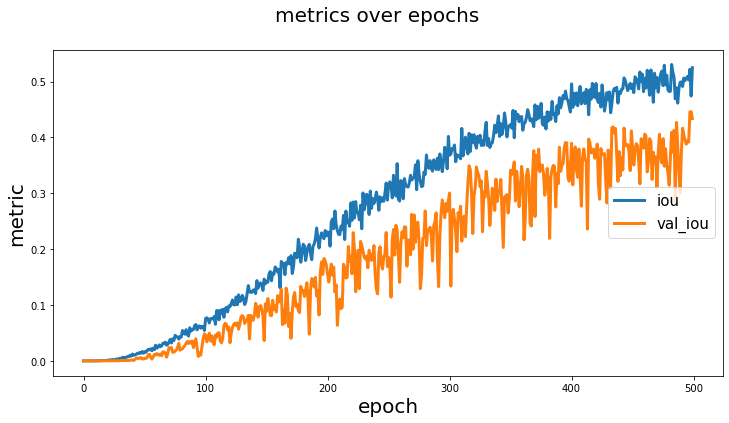

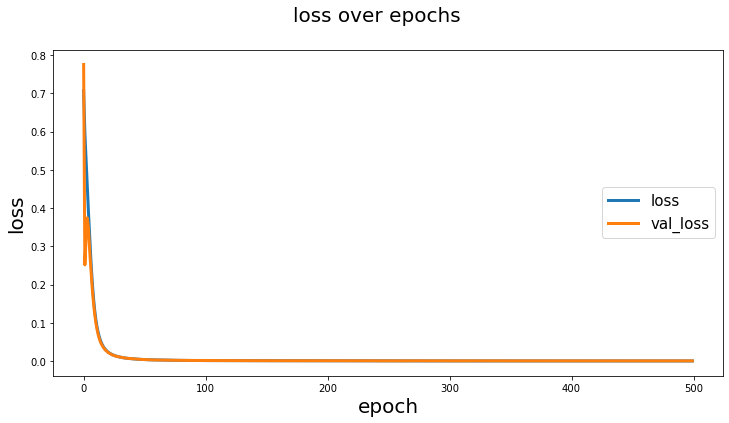

In [20]:
C.Helper.visualize_graph(history)

In [21]:
y_pred = C.Helper.prediction(test_images_array, model)

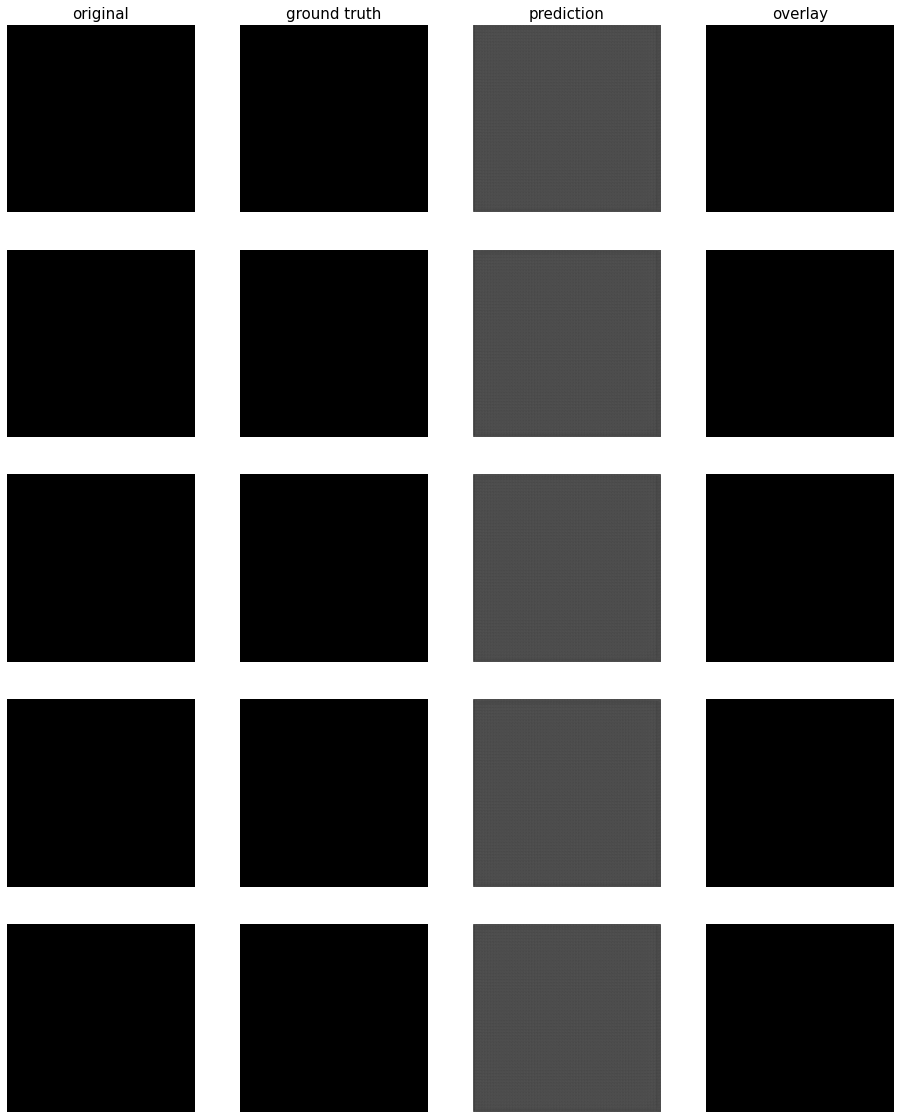

In [22]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [23]:
C.Helper.evaluate(test_images_array, y_test, model)

105/105 [==============================] - 27s 256ms/step - loss: 8.4933e-05 - iou: 0.0520 - iou_thresholded: 0.5693
